# Deep Q Network (DQN)
This notebook is to create an agent that works using Deep Q Network (DQN) over the generic Q Learning approach. 


## Q Learning


Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

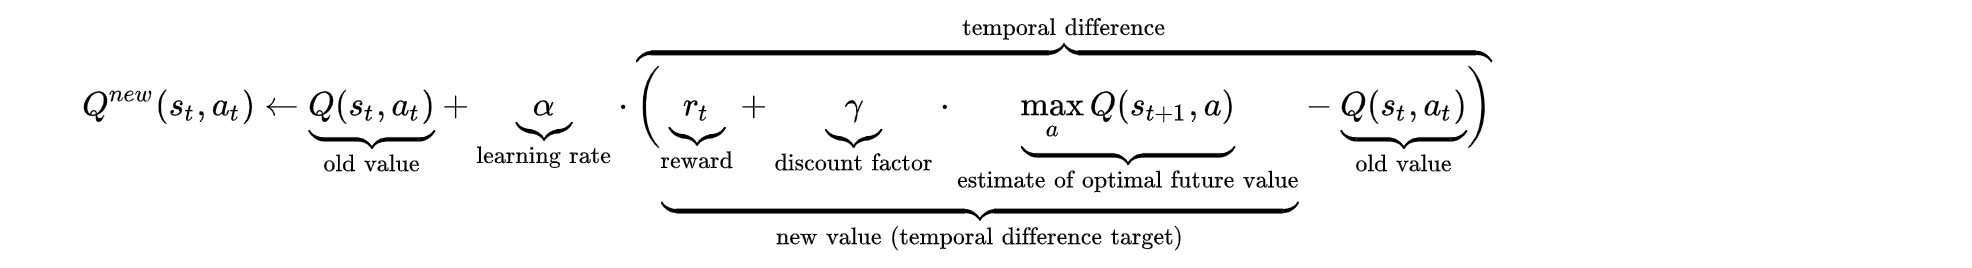

## Deep Q-Networks


In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as the input and the Q-value of all possible actions is generated as the output. The comparison between Q-learning & deep Q-learning is wonderfully illustrated below:

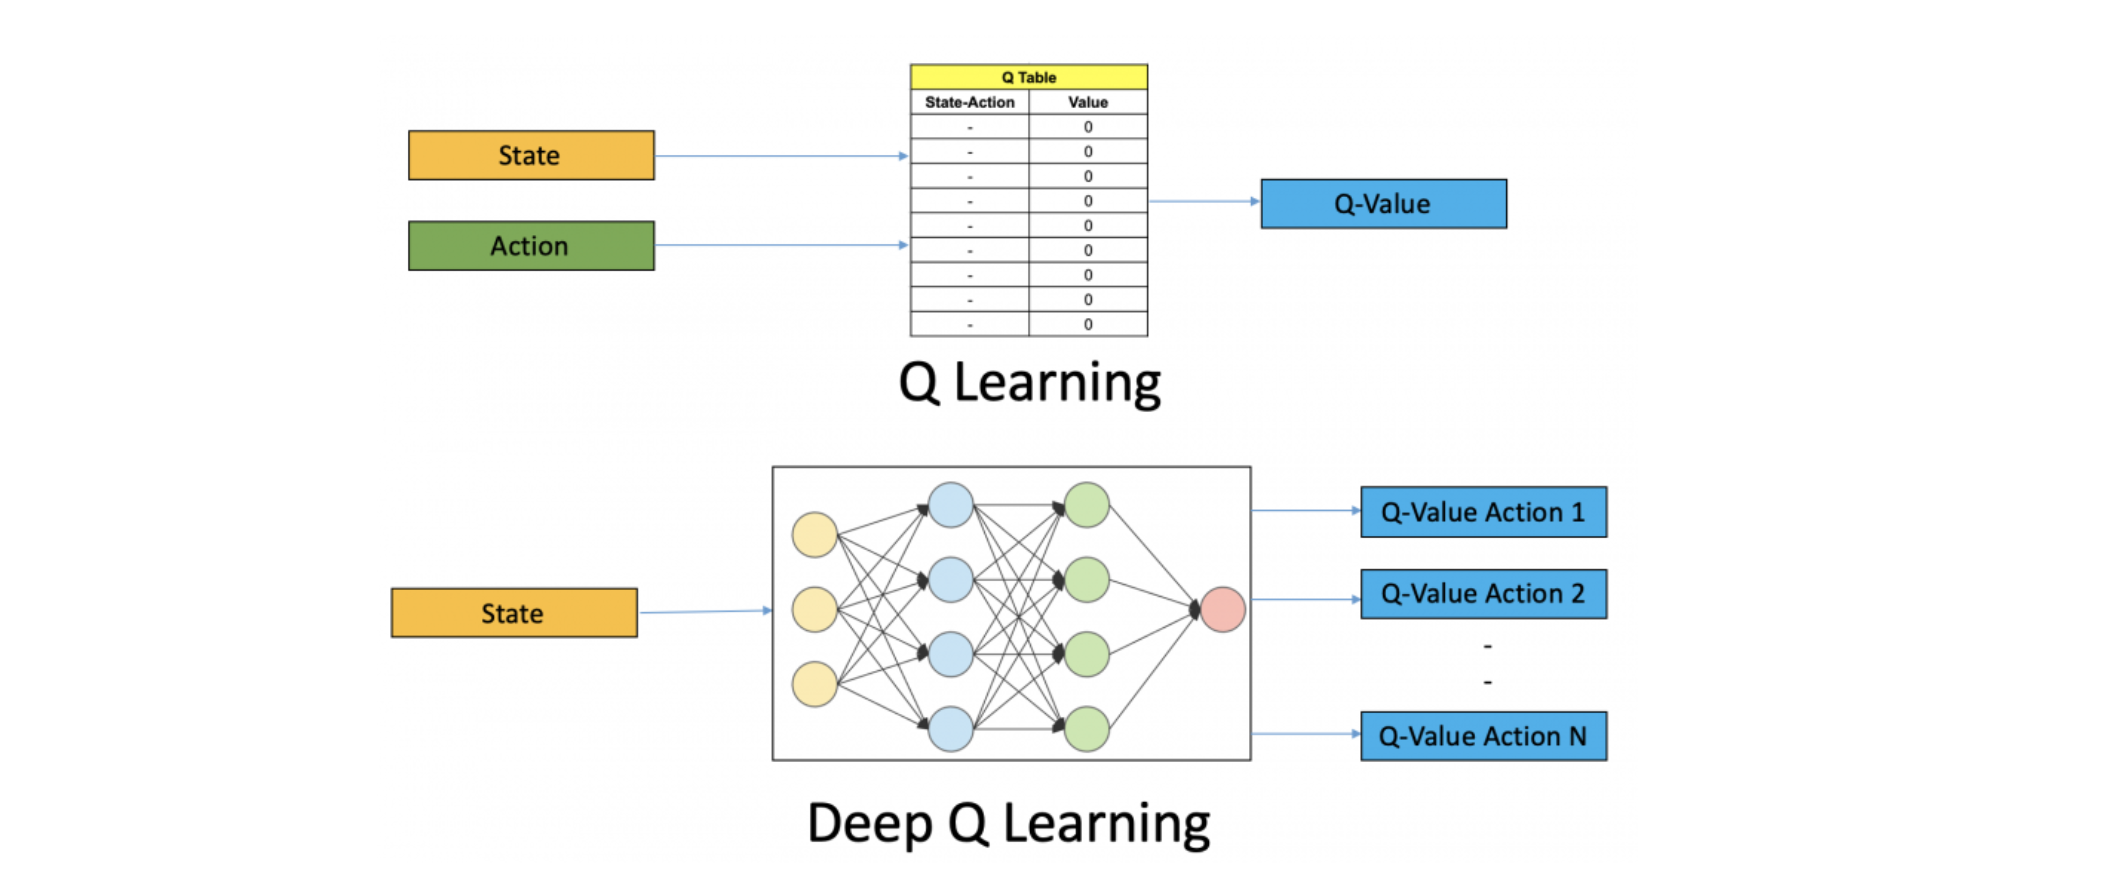


Steps involved in reinforcement learning using deep Q-learning networks (DQNs):

1. All the past experience is stored by the user in memory
2. The next action is determined by the maximum output of the Q-network
3. The loss function here is mean squared error of the predicted Q-value and the target Q-value – Q*. This is basically a regression problem. However, we do not know the target or actual value here as we are dealing with a reinforcement learning problem. Going back to the Q-value update equation derived fromthe Bellman equation. we have:

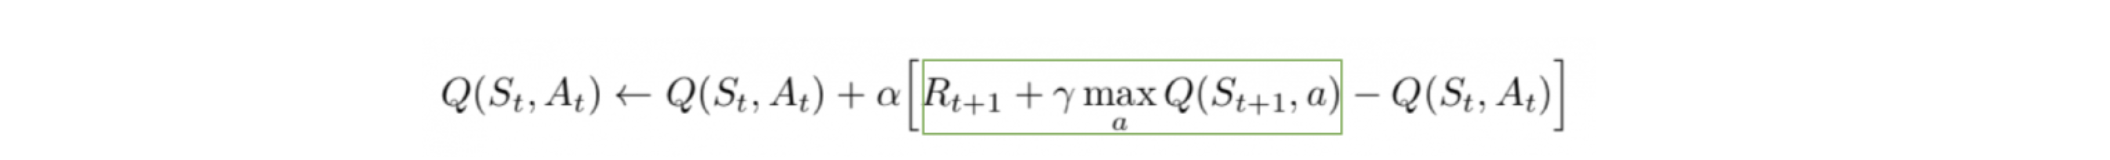

The section in green represents the target. We can argue that it is predicting its own value, but since R is the unbiased true reward, the network is going to update its gradient using backpropagation to finally converge.

## Code walkthrough

Lets create a dqn agent, according to the problem, our agent is called on each new game, with observation has history for lastOpponentAction and Reward.

Thus, we create an agent which does the following - 
1. Create a state map of agent action and opponent action. This will help in creating a single state for transition between states.
2. We can figure out the reward by examining the our last action and last opponent action, "determine_winner" does the same.


In [ ]:

def determine_winner(you, opponent):
    winning_situations = [[0, 2], [2, 1], [1, 0]]
    if [you, opponent] in winning_situations:
        return 1
    elif you == opponent:
        return 0
    else:
        return -1


STATES = {(0, 0): 0,
          (0, 1): 1,
          (0, 2): 2,
          (1, 0): 3,
          (1, 1): 4,
          (1, 2): 5,
          (2, 0): 6,
          (2, 1): 7,
          (2, 2): 8}

current_state = 0
current_action = 0



We create my_dnq_agent which does the following (added comments)

In [ ]:


def my_dqn_agent(observation, configuration):
    global current_state
    global current_action
    global STATES
    global dqn
    dqn.track_reward(observation.reward)
    if observation.step == 0:
                                                    #first step, play random
        current_action = int(np.random.randint(0, 3))
        return current_action
    elif observation.step == 1:
                                                    #second step, keep track of last state ( current_state here)
        current_state = STATES[(current_action, observation.lastOpponentAction)]
        current_action = int(np.random.randint(0, 3))
        return current_action
    else:
                                                    #other steps,
                                                    #find reward
        reward = determine_winner(current_action, observation.lastOpponentAction)
                                                    #find next transition state(our last action and opponent last action)        
        next_state = STATES[(current_action, observation.lastOpponentAction)]
                                                    #Now we have experience tuple (last state, action, new state , reward)
        experience = (current_state, current_action, next_state, reward)
                                                    #our dqn will record and experience this.
        dqn.experience(experience)
                                                    #ask dqn to predict action
        current_action = dqn.act(next_state, current_state)
        current_state = next_state
        return current_action


A DQN ( Deep Q Network ) does the following --
1. Create a Dense network that will learn and estimate q values
2. Record experiences in a replay buffer, and use it for model training at intervals.
3. Predict next action by model.predict() of Q values, selecting argmax
4. Added a reward history queue to track if we are overfitting and loosing to opponent. Play random for a series of neg rewards.

In [ ]:
class DQN():
    def __init__(self):
        self.Q = np.zeros((9, 3))
        self.alpha = 0.7
        self.alpha_decay = 1
        self.discount = 0.31
        self.epsilon = 0.80
        self.epsilon_decay = 0.996
        self.reward_history = deque(maxlen=10)
        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 100
        self.is_batch_applied = False
        self.counter = 0
        self.model = self.create_model()
        self.random_action = 0
        self.prediction_model = 0
        pass

    # Predict states or play random
    
    def act(self, current_state, state_before):
        if self.epsilon > random.uniform(0, 1) or self.is_neg_reward_streak():
            action = int(np.random.randint(0, 3))
        else:
            action_model = self.prediction_by_model(current_state, state_before)
            action = action_model
        return action
    
    # Record experience and train at intervals
    
    def experience(self, exp):
        (c_state, c_action, n_state, n_reward) = exp
        discounted_next_state = self.alpha * (n_reward +
                                              self.discount * self.Q[
                                                  n_state, self.prediction_by_model(n_state, c_state)] -
                                              self.Q[c_state, c_action])

        self.Q[c_state, c_action] = self.Q[c_state, c_action] + discounted_next_state
        z_state_before_c_state = self.state_to_zeros(0)
        if (len(self.replay_memory_buffer) > 0):
            previous_exp = self.replay_memory_buffer[-1]
            (z_state_before_c_state, _, _) = previous_exp
        self.replay_memory_buffer.append(
            (self.state_to_zeros(c_state), z_state_before_c_state, self.Q[c_state, :]))

        self.alpha *= self.alpha_decay
        self.epsilon *= self.epsilon_decay

        self.counter = self.counter + 1
        if (self.counter > self.batch_size / 2):
            self.counter = 0
            samples = random.sample(self.replay_memory_buffer, min(len(self.replay_memory_buffer), self.batch_size))
            (states, q_values) = self.get_attribues_from_sample(samples)
            self.model.fit(states, q_values, verbose=0, batch_size=self.batch_size)
        pass

    def state_to_zeros(self, c_state):
        v = np.zeros(9)
        v[c_state] = 1
        return v

    # Tensor flow dense model
    
    def create_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu, input_dim=18))
        model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(3))
        model.compile(loss=tf.keras.losses.mean_squared_error, optimizer="adam", metrics=['accuracy'])

        # print(model1.summary())
        return model

    def get_attribues_from_sample(self, samples):
        ff = []
        for i in samples:
            current_state = i[0]
            state_before = i[1]
            ff.append(np.append(current_state, state_before))
        states = np.asarray(ff)
        q_values = np.array([i[2] for i in samples])
        return states, q_values

    def prediction_by_model(self, current_state, state_before):
        z_current_state = self.state_to_zeros(current_state)
        z_state_before = self.state_to_zeros(state_before)
        state = np.append(z_current_state, z_state_before).reshape(1, 18)
        pred = self.model.predict(state)
        return int(np.argmax(pred[0]))

    def is_neg_reward_streak(self):
        return all(i < 0 for i in list(self.reward_history))

    def track_reward(self, reward):
        self.reward_history.append(reward)
        pass



## Complete code 

In [ ]:
from collections import deque

import numpy as np
import random
import tensorflow as tf


def determine_winner(you, opponent):
    winning_situations = [[0, 2], [2, 1], [1, 0]]
    if [you, opponent] in winning_situations:
        return 1
    elif you == opponent:
        return 0
    else:
        return -1


STATES = {(0, 0): 0,
          (0, 1): 1,
          (0, 2): 2,
          (1, 0): 3,
          (1, 1): 4,
          (1, 2): 5,
          (2, 0): 6,
          (2, 1): 7,
          (2, 2): 8}

current_state = 0
current_action = 0


class DQN():
    def __init__(self):
        self.Q = np.zeros((9, 3))
        self.alpha = 0.7
        self.alpha_decay = 1
        self.discount = 0.31
        self.epsilon = 0.80
        self.epsilon_decay = 0.996
        self.reward_history = deque(maxlen=10)
        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 100
        self.is_batch_applied = False
        self.counter = 0
        self.model = self.create_model()
        self.random_action = 0
        self.prediction_model = 0
        pass

    def act(self, current_state, state_before):
        if self.epsilon > random.uniform(0, 1) or self.is_neg_reward_streak():
            action = int(np.random.randint(0, 3))
        else:
            action_model = self.prediction_by_model(current_state, state_before)
            action = action_model
        return action

    def experience(self, exp):
        (c_state, c_action, n_state, n_reward) = exp
        discounted_next_state = self.alpha * (n_reward +
                                              self.discount * self.Q[
                                                  n_state, self.prediction_by_model(n_state, c_state)] -
                                              self.Q[c_state, c_action])

        self.Q[c_state, c_action] = self.Q[c_state, c_action] + discounted_next_state
        z_state_before_c_state = self.state_to_zeros(0)
        if (len(self.replay_memory_buffer) > 0):
            previous_exp = self.replay_memory_buffer[-1]
            (z_state_before_c_state, _, _) = previous_exp
        self.replay_memory_buffer.append(
            (self.state_to_zeros(c_state), z_state_before_c_state, self.Q[c_state, :]))

        self.alpha *= self.alpha_decay
        self.epsilon *= self.epsilon_decay

        self.counter = self.counter + 1
        if (self.counter > self.batch_size / 2):
            self.counter = 0
            samples = random.sample(self.replay_memory_buffer, min(len(self.replay_memory_buffer), self.batch_size))
            (states, q_values) = self.get_attribues_from_sample(samples)
            self.model.fit(states, q_values, verbose=0, batch_size=self.batch_size)
        pass

    def state_to_zeros(self, c_state):
        v = np.zeros(9)
        v[c_state] = 1
        return v

    def create_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu, input_dim=18))
        model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(3))
        model.compile(loss=tf.keras.losses.mean_squared_error, optimizer="adam", metrics=['accuracy'])

        # print(model1.summary())
        return model

    def get_attribues_from_sample(self, samples):
        ff = []
        for i in samples:
            current_state = i[0]
            state_before = i[1]
            ff.append(np.append(current_state, state_before))
        states = np.asarray(ff)
        q_values = np.array([i[2] for i in samples])
        return states, q_values

    def prediction_by_model(self, current_state, state_before):
        z_current_state = self.state_to_zeros(current_state)
        z_state_before = self.state_to_zeros(state_before)
        state = np.append(z_current_state, z_state_before).reshape(1, 18)
        pred = self.model.predict(state)
        return int(np.argmax(pred[0]))

    def is_neg_reward_streak(self):
        return all(i < 0 for i in list(self.reward_history))

    def track_reward(self, reward):
        self.reward_history.append(reward)
        pass


dqn = DQN()


def dqn_agent(observation, configuration):
    global current_state
    global current_action
    global STATES
    global dqn
    dqn.track_reward(observation.reward)
    if observation.step == 0:
        current_action = int(np.random.randint(0, 3))
        return current_action
    elif observation.step == 1:
        current_state = STATES[(current_action, observation.lastOpponentAction)]
        current_action = int(np.random.randint(0, 3))
        return current_action
    else:
        reward = determine_winner(current_action, observation.lastOpponentAction)
        next_state = STATES[(current_action, observation.lastOpponentAction)]
        experience = (current_state, current_action, next_state, reward)
        dqn.experience(experience)

        current_action = dqn.act(next_state, current_state)
        current_state = next_state
        return current_action


In [ ]:
from kaggle_environments import evaluate, make, utils

env = make("rps", configuration={"episodeSteps": 1000}, debug=True)

In [ ]:
q_learning_demo="/kaggle/input/rps-bot-files/q_learning_demo.py"
rock="/kaggle/input/rps-bot-files/rock.py"


In [ ]:
env.run([q_learning_demo, rock])
print(env.render(mode="ansi"))